In [65]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo
from scipy.optimize import curve_fit
import scipy.interpolate as inp

#bo.cloud.set_verbosity('QUIET')
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

# Setting Simulation Parameters based off Optimized Pulse

In [29]:
# Set parameters.
omega_val = 4715847.175031312 * 2 * np.pi # rad/s
delta_val = 1661548.902926351 * 2 * np.pi # rad/s
tau = 0.4 * 1e-6 # s

# Define the control.
segment_count = 2
sample_times = np.linspace(0, tau, 200)

# Define basis.
basis_labels = ['0', '1', 'r', '11', 'W']

# Components for the drive operator.
drive_operator = np.zeros((5, 5))
drive_operator[1, 2] = 1
drive_operator[3, 4] = np.sqrt(2)

# Components for the detuning operator.
detuning_operator = np.diag([0, 0, -1, 0, -1])

# Components for the CZ operator.
cz_0 = np.diag([1, 0, 0, 0, 0])
cz_1 = np.diag([0, 1, 0, 0, 0])
cz_11 = np.diag([0, 0, 0, 1, 0])

# Defining Function to Acquire Simulation Graph

In [52]:
def get_optimized_graph(detuning_offset = 0, amplitude_offset = 0):
    graph = bo.Graph()

    # Real piece-wise constant signal representing the detuning.
    delta = (
        graph.pwc_signal(
            values=np.array([delta_val + detuning_offset, delta_val+detuning_offset]), 
            duration = tau, 
            name = 'delta'
        )
    )

    # Real piece-wise constant signal representing the Rabi amplitude.
    omega = (
        graph.pwc_signal(
            values= np.array([omega_val+amplitude_offset, omega_val+amplitude_offset]), 
            duration = tau, 
            name = 'omega'
        )
    )

    # Real piece-wise constant signal representing the Rabi phase.
    phi = graph.pwc_signal(
            values=np.array([0,2.0879634634442628]),
            duration=tau,
            name = 'phi'
        )


    # Real scalar signal representing the single qubit phase.
    psi = 2.087963135961016

    # Define the Hamiltonian.
    hamiltonian = (
        graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
        delta * detuning_operator
    )

    # Define the target operator.
    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )

    # Unitary time evolution.
    unitary = (
        graph.time_evolution_operators_pwc(
            hamiltonian = hamiltonian, 
            sample_times = sample_times, 
            name = 'unitary'
        )
    )

    # Infidelity.
    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            name = 'infidelity'
        )
    )

    # Cost function.
    cost_function = (
        graph.sum(
            infidelity
        )
    )
    cost_function.name = 'cost_function'
    
    return graph

## Experiment: How do Detuning Offsets affect Fidelity

In [92]:
def generate_detuning_fidelity(detuning_offsets):
    # Defining output array 
    infidelities_arr = np.zeros(detuning_offsets.shape)

    #Running simulations for all detuning offsets
    for d_idx in range(len(detuning_offsets)):
        result = (
            bo.execute_graph(
                graph = get_optimized_graph(detuning_offset=detuning_offsets[d_idx]),
                #cost_node_name = 'cost_function',
                output_node_names = [ 
                    'unitary',
                    'infidelity'
                ]
            )
        )
        infidelities_arr[d_idx] = result['output']['infidelity']['value']
    return infidelities_arr

In [93]:
# Defining Detuning offsets to test over -delta to delta
detuning_offsets_coarse = np.linspace(-delta_val * 0.1, delta_val * 0.1, 51)
infidelities_arr_detune_coarse = generate_detuning_fidelity(detuning_offsets_coarse)

Your task (action_id="1996799") has started.
Your task (action_id="1996799") has completed.
Your task (action_id="1996800") has started.
Your task (action_id="1996800") has completed.
Your task (action_id="1996801") has started.
Your task (action_id="1996801") has completed.
Your task (action_id="1996802") has started.
Your task (action_id="1996802") has completed.
Your task (action_id="1996803") has started.
Your task (action_id="1996803") has completed.
Your task (action_id="1996804") has started.
Your task (action_id="1996804") has completed.
Your task (action_id="1996805") has started.
Your task (action_id="1996805") has completed.
Your task (action_id="1996806") has started.
Your task (action_id="1996806") has completed.
Your task (action_id="1996807") has started.
Your task (action_id="1996807") has completed.
Your task (action_id="1996808") has started.
Your task (action_id="1996808") has completed.
Your task (action_id="1996809") has started.
Your task (action_id="1996809") has

Text(0.5, 1.0, 'Fidelity as a Function of Detuning Offset')

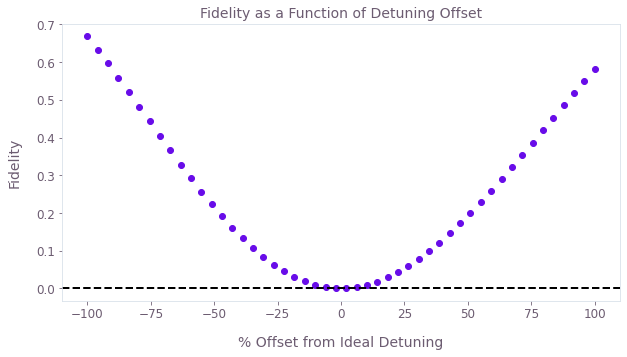

In [63]:
# Plotting Results
plt.scatter(100 * detuning_offsets_coarse/delta_val, infidelities_arr_detune_coarse)
plt.xlabel("% Offset from Ideal Detuning")
plt.ylabel("Fidelity")
plt.axhline(0, color='black', linestyle='dashed')
plt.title("Fidelity as a Function of Detuning Offset")

[ 1.06178522e-07  2.93435722e+05  6.08980525e+06 -6.47911645e-01]


Text(0.5, 1.0, 'Fidelity as a Function of Detuning Offset')

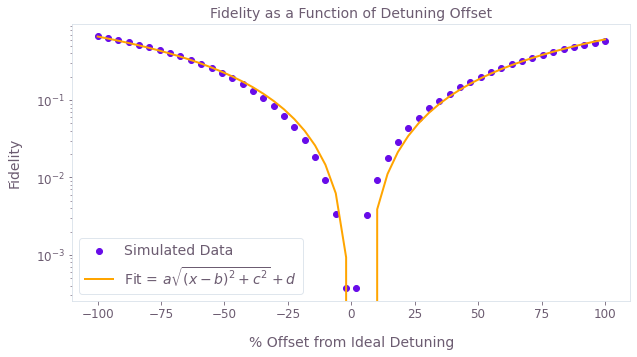

In [91]:
def fit_dirac_dispersion(x, a, b, c , e):
    return a * np.sqrt(((x-b))**2 + c**2) + e

a_guess = np.abs((infidelities_arr_detune_coarse[-1]-infidelities_arr_detune_coarse[-2])/(detuning_offsets_coarse[-1]-detuning_offsets_coarse[-2]))
popt, pcov = curve_fit(fit_dirac_dispersion, detuning_offsets_coarse, infidelities_arr_detune_coarse, p0=[a_guess, 0, 5E5, 0])
aOpt, bOpt, cOpt, eOpt = popt
plt.scatter(100 * detuning_offsets_coarse/delta_val, infidelities_arr_detune_coarse, label='Simulated Data')
print(popt)
plt.plot(100 * detuning_offsets_coarse/delta_val, fit_dirac_dispersion(detuning_offsets_coarse, aOpt, bOpt, cOpt, eOpt), color='orange', label="Fit = " + r"$a \sqrt{(x-b)^2 + c^2} + d$")
plt.xlabel("% Offset from Ideal Detuning")
plt.ylabel("Fidelity")
plt.yscale('log')
plt.axhline(0, color='black', linestyle='dashed')
plt.legend()
plt.title("Fidelity as a Function of Detuning Offset")

In [99]:
# Defining Detuning offsets to test fidelity over -0.1 * delta to 0.1 * delta
detuning_offsets_fine = np.linspace(-10 * delta_val/100, 10 * delta_val/100, 51)
infidelities_arr_detune_fine = generate_detuning_fidelity(detuning_offsets_fine)

Your task (action_id="1996849") has started.
Your task (action_id="1996849") has completed.
Your task (action_id="1996850") has started.
Your task (action_id="1996850") has completed.
Your task (action_id="1996851") has started.
Your task (action_id="1996851") has completed.
Your task (action_id="1996852") has started.
Your task (action_id="1996852") has completed.
Your task (action_id="1996853") has started.
Your task (action_id="1996853") has completed.
Your task (action_id="1996854") has started.
Your task (action_id="1996854") has completed.
Your task (action_id="1996855") has started.
Your task (action_id="1996855") has completed.
Your task (action_id="1996856") has started.
Your task (action_id="1996856") has completed.
Your task (action_id="1996857") has started.
Your task (action_id="1996857") has completed.
Your task (action_id="1996858") has started.
Your task (action_id="1996858") has completed.
Your task (action_id="1996859") has started.
Your task (action_id="1996859") has

a = 8.9e-05 
b = -6.6e-06


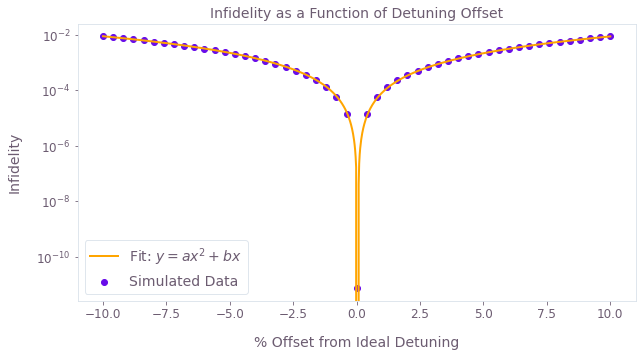

In [135]:
# Plotting Results
plt.xlabel("% Offset from Ideal Detuning")
plt.ylabel("Infidelity")
plt.yscale("log")
a, b, c = np.polyfit(100 * detuning_offsets_fine/delta_val, infidelities_arr_detune_fine, 2)
sim_x = np.linspace(-10, 10, 1001)
plt.plot(sim_x, a * sim_x ** 2 + b * sim_x , color="orange", label="Fit: "  + r"$y = ax^{2} + bx$", zorder=1)
plt.scatter(100 * detuning_offsets_fine/delta_val, infidelities_arr_detune_fine, zorder=0, label='Simulated Data')
plt.title("Infidelity as a Function of Detuning Offset")
plt.legend()
print(f"a = {a:.2g}", f"\nb = {b:.2g}")

## Experiment: How do Amplitude Offsets affect Fidelity

In [101]:
amplitude_offsets = np.linspace(-omega_val * 0.1, omega_val*0.1, 51) 
infidelities_arr_amp = np.zeros(amplitude_offsets.shape)
for a_idx in range(len(amplitude_offsets)):
    result = (
        bo.execute_graph(
            graph = get_optimized_graph(amplitude_offset=amplitude_offsets[a_idx]),
            #cost_node_name = 'cost_function',
            output_node_names = [ 
                'unitary',
                'infidelity'
            ]
        )
    )
    infidelities_arr_amp[a_idx] = result['output']['infidelity']['value']

Your task (action_id="1996900") has started.
Your task (action_id="1996900") has completed.
Your task (action_id="1996901") has started.
Your task (action_id="1996901") has completed.
Your task (action_id="1996902") has started.
Your task (action_id="1996902") has completed.
Your task (action_id="1996903") has started.
Your task (action_id="1996903") has completed.
Your task (action_id="1996904") has started.
Your task (action_id="1996904") has completed.
Your task (action_id="1996905") has started.
Your task (action_id="1996905") has completed.
Your task (action_id="1996906") has started.
Your task (action_id="1996906") has completed.
Your task (action_id="1996907") has started.
Your task (action_id="1996907") has completed.
Your task (action_id="1996908") has started.
Your task (action_id="1996908") has completed.
Your task (action_id="1996909") is queued.
Your task (action_id="1996909") has completed.
Your task (action_id="1996910") has started.
Your task (action_id="1996910") has c

a = 0.00072 
b = 0.00029


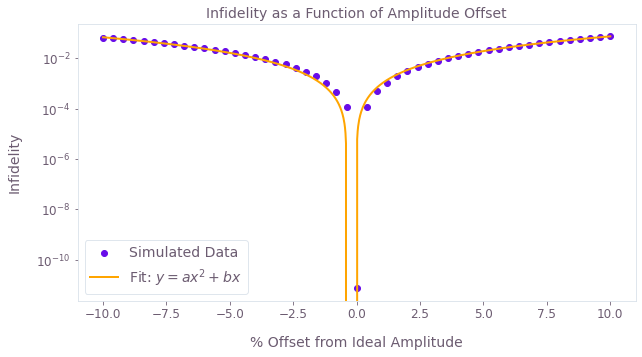

In [134]:
plt.scatter(100 * amplitude_offsets/omega_val, infidelities_arr_amp, zorder=1, label="Simulated Data")
plt.yscale('log')
plt.xlabel("% Offset from Ideal Amplitude")
a, b, c = np.polyfit(100 * amplitude_offsets/omega_val, infidelities_arr_amp, 2)
x_fit = np.linspace(-10, 10, 1001)
plt.plot(x_fit, a * x_fit**2 + b * x_fit, color='orange', zorder=1, label="Fit: "  + r"$y = ax^{2} + bx$")
plt.ylabel("Infidelity")
#plt.axhline(1, color='black', linestyle='dashed')
plt.title("Infidelity as a Function of Amplitude Offset")
plt.legend()
print(f"a = {a:.2g}", f"\nb = {b:.2g}")